# Agentes en LangGraph con Gemini


## Caso 6 Evaluador-optimizador

<img src="https://langchain-ai.github.io/langgraph/tutorials/workflows/img/evaluator_optimizer.png" alt="gate" width="600"/>

En el flujo de trabajo evaluador-optimizador, una llamada al LLM genera una respuesta mientras que otra proporciona evaluación y retroalimentación en un ciclo:

Cuándo usar este flujo de trabajo: Este flujo es particularmente efectivo cuando tenemos criterios de evaluación claros y cuando la refinación iterativa aporta un valor medible. Las dos señales de buen ajuste son, primero, que las respuestas del LLM pueden mejorarse demostrablemente cuando un humano articula su retroalimentación; y segundo, que el LLM puede proporcionar dicha retroalimentación. Esto es análogo al proceso iterativo de escritura que un escritor humano podría seguir al producir un documento pulido.


In [1]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
# from langchain_core.messages import HumanMessage, SystemMessage
from typing_extensions import Literal

In [2]:
import os
import getpass
from langchain_google_genai import ChatGoogleGenerativeAI

# Declaración y llamado de la key del modelo LLM
# use esta función para definir la key del modelo LLM si tuvo problemas con el archivo .env.json o create_env.py
def _set_env(var: str):
   if not os.environ.get(var):
       os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

Iniciamos definiendo los estados del grafo:

In [3]:
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

Ahora definimos un esquema que nos ayudará a calificar la calidad del chiste

In [4]:
# Esquema para salida estructurada a usar en la evaluación
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide si el chiste es gracioso o no.",
    )
    feedback: str = Field(
        description="Si el chiste no es gracioso, proporciona retroalimentación sobre cómo mejorarlo.",
    )

Definimos el LLM con un esquema para salida estructurada

In [5]:
evaluator = llm.with_structured_output(Feedback)

Ahora definimos las funciones que nos servirán como nodos

In [6]:
def llm_call_generator(state: State):
    """El LLM genera un chiste"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Escribe un chiste sobre {state['topic']} pero toma en cuenta la retroalimentación: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Escribe un chiste sobre {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """El LLM evalúa el chiste"""

    grade = evaluator.invoke(f"Califica el chiste {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Función condicional para regresar al generador de chistes o terminar según la retroalimentación del evaluador
def route_joke(state: State):
    """Regresa al generador de chistes o termina según la retroalimentación del evaluador"""

    if state["funny_or_not"] == "funny":
        return "Aceptado"
    elif state["funny_or_not"] == "not funny":
        return "Rechazado + Retroalimentación"


Inicializamos el grafo

In [7]:
optimizer_builder = StateGraph(State)

Agregamos al grafo los nodos que antes habíamos definido

In [8]:
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

Agregamos las aristas al grafo para darle forma y las conexiones entre los nodos agregados en el paso anterior

In [9]:
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Nombre devuelto por route_joke : Nombre del siguiente nodo a visitar
        "Aceptado": END,
        "Rechazado + Retroalimentación": "llm_call_generator",
    },
)


Con todo esto, ya se puede compilar el grafo

In [10]:
optimizer_workflow = optimizer_builder.compile()

Visualizamos el grafo

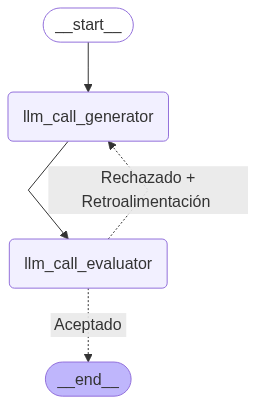

In [11]:
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

Finalmente probamos nuestro flujo haciendo una invocación al grafo

In [12]:
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

¿Qué le dijo un gato al otro?

¡Nos vemos más tarde, tengo que ir a una fiesta de miau-sicina!
